In [1]:
# Import libraries
import warnings
import IPython
import matplotlib.pyplot as plt
import os
import numpy as np
from pathlib import Path
import scipy.stats as stats
from pylab import rcParams
import pandas as pd
import sys
sys.path.append('../')

# Import RadDBS-QSM modules
import util
import loader
import extract
import train

In [2]:
os.environ["PYTHONWARNINGS"] = ('ignore::UserWarning')
# Find the repository path
raddbs_path = loader.get_raddbs_path(
    "/".join(IPython.extract_module_locals()[1]["__vsc_ipynb_file__"].split("/")))
nii_dir = '/data/nii/chh/orig/'

In [3]:
raddbs_path

'/data/Ali/RadDBS-QSM/'

In [4]:
segs = []
qsms = []
# Assuming `nii_dir` input contains subdirectories `qsm`, `seg`, and `masks`
try:
    segs,qsms,n_cases = loader.s1data(raddbs_path,nii_dir,False)
except:
    print('Using demo data')
# Add your QSM, or use default radiomic feature

Using demo data


In [5]:
# Load clinical variables
df = pd.read_csv(Path(raddbs_path+'/data/xlxs/updrs_iii_chh_cvs.csv'))
age,sex,dd,ledd,subsc,pre_updrs_off,pre_updrs_on,post_updrs_off,per_change,lct_change = loader.s1cvdata(df,segs,raddbs_path,nii_dir,False)

Using demo case IDs


In [6]:
# Obtain the feature value matrix X, feature labels K, and ROIs R
X_all_c,K_all_c,R_all_c = extract.feature_matrix(raddbs_path,segs,qsms,subsc,reextract=0)

Estimator predicts 0.7884 for case with 0.72 and selected CV 5 and 86 minority cases using random state 1 and sample size (418, 388)
Estimator predicts 0.5933 for case with 0.47 and selected CV 4 and 83 minority cases using random state 1 and sample size (418, 3388)
Estimator predicts 0.8915 for case with 0.69 and selected CV 5 and 86 minority cases using random state 1 and sample size (418, 388)
Estimator predicts 0.7326 for case with 0.42 and selected CV 5 and 83 minority cases using random state 1 and sample size (418, 6388)
Estimator predicts 0.2858 for case with 0.15 and selected CV 2 and 163 minority cases using random state 1 and sample size (429, 388)
Estimator predicts 0.5768 for case with 0.44 and selected CV 5 and 83 minority cases using random state 1 and sample size (418, 6388)
Estimator predicts 0.8324 for case with 0.88 and selected CV 5 and 84 minority cases using random state 1 and sample size (418, 6388)
Estimator predicts 0.5139 for case with 0.4 and selected CV 4 an

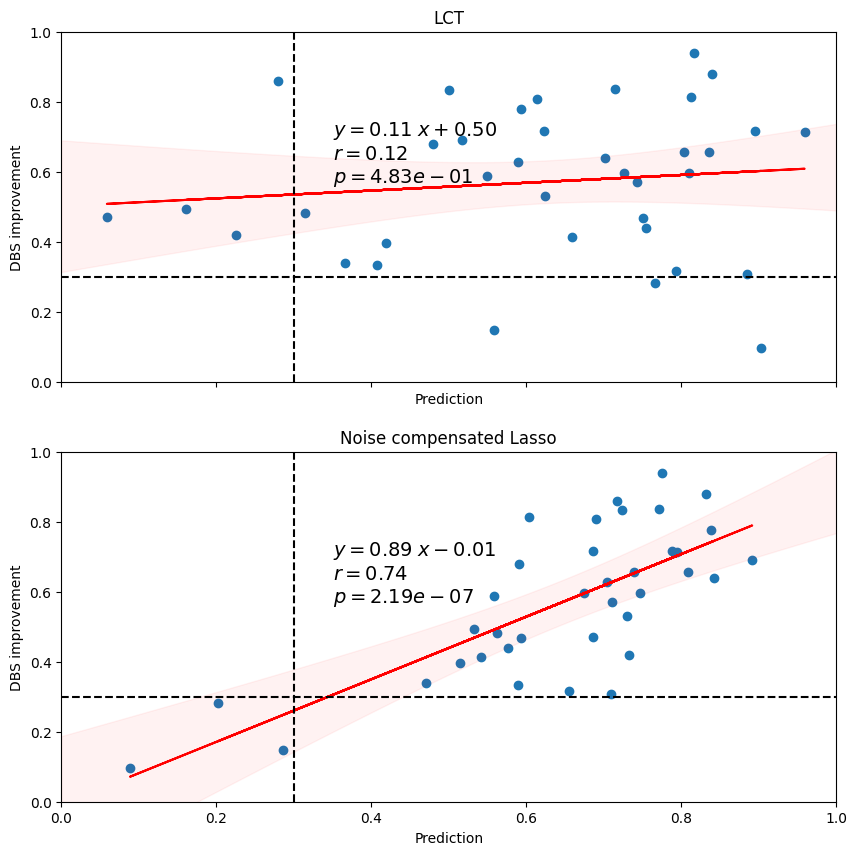

In [7]:
# Train estimators
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
results_ls_aug = train.train_estimator(subsc,X_all_c,K_all_c,per_change,pre_updrs_on,age,sex,dd,None,'nc_iid_q',True,True,1,True)
util.eval_prediction(np.vstack((lct_change,results_ls_aug)),per_change,['LCT','Noise compensated Lasso'],[20,5])